## My First Kaggle Entry and My First Python ML Script!

### Preprocessing data

#### Preliminary Check

In [35]:
import pandas as pd
import numpy as np

In [40]:
df_train = pd.read_csv('D:/Grad Study!/Geeky things (Competition/Titanic/train.csv')
df_test = pd.read_csv('D:/Grad Study!/Geeky things (Competition/Titanic/test.csv')

In [41]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [42]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [43]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

#### Feature Engineering

Inspired by many Kaggle kernels on feature engineering, I will create the following features:
- *FamilySize*: SibSp+Parch+1
- *IsAlone*: whether the passenger is alone on Titanic
- *HasCabin* : whether the passenger has a separate cabin 
- *FareCat* : which category this ticket belongs to

In [56]:
full_data = [df_train,df_test]

#Family Size
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

#IsAlone
for dataset in full_data:
    dataset['IsAlone'] = dataset["FamilySize"].apply(lambda x: 1 if x == 1 else 0)
    
#HasCabin
for dataset in full_data:
    dataset['HasCabin'] = dataset["Cabin"].apply(lambda x: 1 if pd.isnull(x) == False else 0)

Before looking into ticket fare categories, I first want to check the relationship between *Fare* and *PClass*.

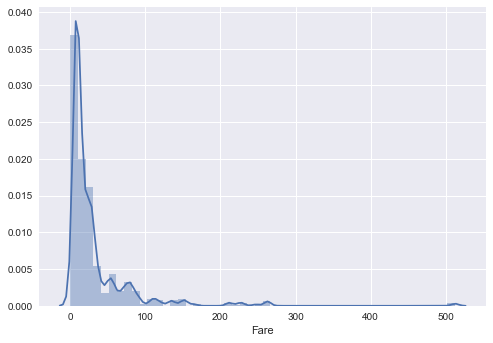

In [59]:
import seaborn as sns
sns.distplot(df_train['Fare'])
sns.plt.show()

As the density plot shows, ticket price can go as high as above $500. Let's check the price distribution for each class.

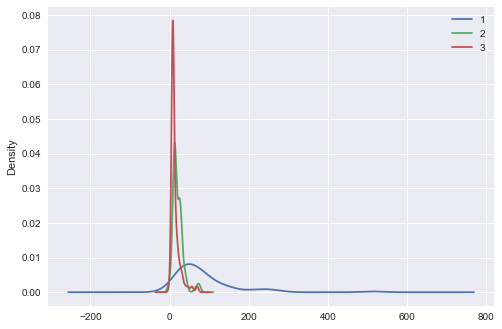

In [70]:
import matplotlib.pyplot as plt
df_train.groupby('Pclass')['Fare'].plot(kind='density',legend=True)
plt.show()

As expected, ticket prices are very different among the 3 classes. But there seem to have overlap between ticket class and ticket price (instead of having a clear price cutoff within each class). *FareCat* might be helpful for classification later.

In [76]:
#FareCat
for dataset in full_data:
    dataset['FareCat'] = pd.qcut(dataset['Fare'], 5)

#### Impute missing values

Most of the missing values come from *Age* and *Cabin*. Since I have a *HasCabin* variable now, I only need to deal with *Age*. There are a few ways to impute missing values:

- fill in with mean or median (depends on distribution)
- 'predict' using other columns

Firstly, I checked the overall age distribution. 

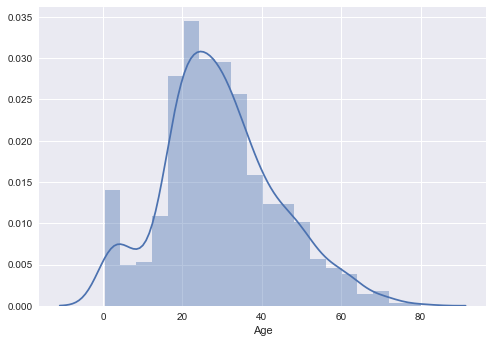

In [78]:
sns.distplot(df_train['Age'].dropna())
sns.plt.show()

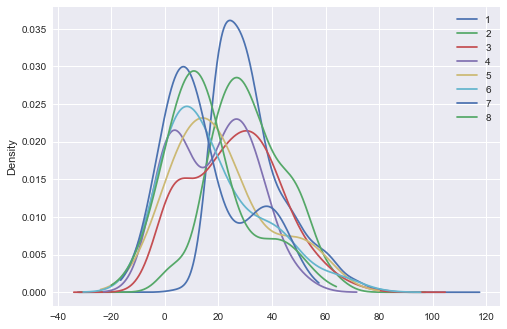

In [86]:
df_train.groupby(['FamilySize'])['Age'].describe()
plt.show()

In [9]:
from sklearn.preprocessing import Imputer
imp_age = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp_age = imp_age.fit_transform(df_train['Age'].values.reshape(-1,1))

In [10]:
port_mapping = {label:idx for idx, label in enumerate(np.unique(df_train['Embarked']))}
df_train['portlabel'] = df_train['Embarked'].map(port_mapping)

C:\Users\DSHH\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\numpy\lib\arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


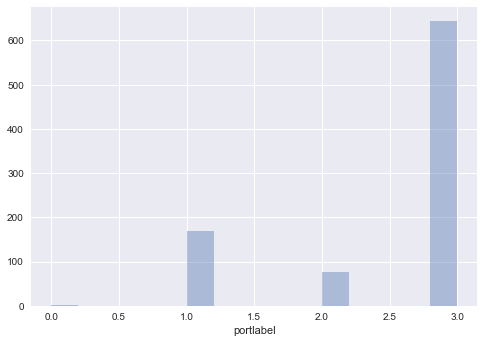

In [11]:
sns.distplot(a=df_train['portlabel'],hist=True,kde=False,rug=False)
sns.plt.show()

In [12]:
df_train['Age'] = imp_age
df_train['Embarked'][df_train['Embarked'].isnull() == True] = 'S'

C:\Users\DSHH\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [13]:
df_train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Embarked       0
portlabel      0
dtype: int64

In [14]:
df_train = df_train.drop('portlabel',axis=1)
df = pd.get_dummies(df_train, columns = ['Pclass','Sex','Embarked'],drop_first=True)

### Modeling

In order to solve this classification problem, I intend to use the following algorithms and see which one gives the best results:
- Logistic Regression
- Decision Tree
- Random Forest (because ensemble method usually gives better results)

In [15]:
X = df.drop(['Survived'],axis=1)
y = df['Survived']

In [16]:
X.head(5)

,PassengerId,Age,SibSp,Parch,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
0,1,22.0,1,0,0,1,1,0,1
1,2,38.0,1,0,0,0,0,0,0
2,3,26.0,0,0,0,1,0,0,1
3,4,35.0,1,0,0,0,0,0,1
4,5,35.0,0,0,0,1,1,0,1


In [17]:
y.head(5)

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [18]:
from sklearn.model_selection import train_test_split,RandomizedSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix,accuracy_score

Split on the train data because I want to leave a validation dataset, it will be 10% of the train data.

In [19]:
np.random.seed(323212)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.1, random_state = 42)

#### 1. Logistic Regression

In [20]:
logreg = LogisticRegression()
c_space = np.logspace(-5,8,50)
param_grid = {'penalty':['l1','l2'],'C':c_space}
logreg_cv = RandomizedSearchCV(logreg,param_grid,cv=5)
logreg_cv.fit(X_train,y_train)
print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameter: {'penalty': 'l2', 'C': 6.8664884500430121}
Tuned Logistic Regression Accuracy: 0.791510611735


In [21]:
y_pred = logreg_cv.predict(X_test)
accuracy_score(y_test,y_pred)

0.84444444444444444

#### 2. Decision Tree

In [31]:
tree = DecisionTreeClassifier()
param_dist = {"max_depth": np.arange(1,9,1),
              "max_features": np.arange(1,9,1),
              "min_samples_leaf": np.arange(1,9,1),
              "criterion": ["gini", "entropy"]}
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)
tree_cv.fit(X_train,y_train)
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'max_features': 3, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 3}
Best score is 0.810237203496


In [32]:
y_pred_tree = tree_cv.predict(X_test)
accuracy_score(y_test,y_pred_tree)

0.83333333333333337

#### 3. Random Forest

In [33]:
rf = RandomForestClassifier()
param_rf = {'n_estimators':np.arange(100,1000,100),
           'criterion':['gini','entropy'],
           'max_depth':np.arange(1,20,1)}
rf_cv = RandomizedSearchCV(rf,param_rf,cv=5)
rf_fit = rf_cv.fit(X_train,y_train)
print("Tuned Decision Tree Parameters: {}".format(rf_cv.best_params_))
print("Best score is {}".format(rf_cv.best_score_))

Tuned Decision Tree Parameters: {'n_estimators': 300, 'criterion': 'gini', 'max_depth': 5}
Best score is 0.822721598002


In [34]:
y_pred_rf = rf_cv.predict(X_test)
accuracy_score(y_test,y_pred_rf)

0.82222222222222219

### Test on the testing set

In [23]:
df_test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [24]:
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [25]:
df_test = df_test.drop(cols,axis=1)

In [26]:
imp_age_test = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp_age_test = imp_age_test.fit_transform(df_test['Age'].values.reshape(-1,1))

In [27]:
df_test['Age'] = imp_age_test
df_test = pd.get_dummies(df_test, columns = ['Pclass','Sex','Embarked'],drop_first=True)

In [28]:
df_test.head(5)

,PassengerId,Age,SibSp,Parch,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
0,892,34.5,0,0,0,1,1,1,0
1,893,47.0,1,0,0,1,0,0,1
2,894,62.0,0,0,1,0,1,1,0
3,895,27.0,0,0,0,1,1,0,1
4,896,22.0,1,1,0,1,0,0,1


In [29]:
prediction = logreg_cv.predict(df_test)

In [30]:
Submission = pd.DataFrame({ 'PassengerId': df_test['PassengerId'],
                            'Survived': prediction })
Submission.to_csv("Submission.csv", index=False)